# Homework 3

* Manuel Balzan, 1936818
* Mohammad Iman Sayyadzadeh, 1909091
* Adrienn Timea Aszalos, 1599831

### IMPORTANT!!

don't run all the file (the data engineering parts require a lot of time and some parts are not reproducible because the htmls are missing). You can just import the .py files and the libraries, then move to paragraph 2.1, from the second block of code and try the search engines if you want.

## Goal of the homework:

Build a search engine over the "best books ever" list from GoodReads.

## 0. Importing Py Files

In [2]:
from get_urls import *                 # Ex. 1
from download_htmls import *           # Ex. 1
from parse_htmls import *              # Ex. 1
from text_preprocessing import *       # Ex. 2
from search_engines import *           # Ex. 2-3
from plot_book_series import *         # Ex. 4
import time
import matplotlib.pyplot as plt
import numpy as np
import string
import random

## 1. Data Collection

In this first part we collect data from the Goodreads website and store it in tsv files.

### 1.1 Get the list of books

We are interested in gathering the URLs of all the books from the first 300 pages of section 'Best Books Ever'.

To do so first specify the URL of the first 'Goodreads Best Books Ever' page, the prefix of all Goodreads pages, and the prefix of all 'Goodreads Best Book Ever' pages after the first.

Then we apply the functions from get_urls.py to get the book URLs for the first 300 pages and store them in a .txt file.

(the functions for this part can be found in '**get_urls.py**')

In [ ]:
target_page = 'https://www.goodreads.com/list/show/1.Best_Books_Ever'
url_prefix = 'https://www.goodreads.com'
page_prefix = 'https://www.goodreads.com/list/show/1.Best_Books_Ever?page='
    

urls = get_all_pages_urls(target_page, 300, url_prefix, page_prefix)

store_in_txt(urls,'books_urls.txt')

### 1.2 Crawl books

Now we want to store the html for each of the books in our .txt file.

To do so, we iterate over each URL in the .txt file, downloading the page and storing it in an .html file. The files are saved in a folder named 'htmls'.

(the functions for this part can be found in '**download_htmls.py**')

In [ ]:
directory = os.getcwd()+'\htmls\\'
driver = webdriver.Firefox(executable_path=GeckoDriverManager().install())

run_html_downloader(driver, 1, 30000, directory)

### 1.3 Parse downloaded pages

For the last part of Ex. 1, we need to parse each of the htmls, extracting some specific fields and storing each parsed book in a .tsv file. If the plot is not in English, we skip the book (without storing anything) and move to the next one.

To do so, we define a function to parse each field and, for each html, we call all these function and store the output in a .tsv file. The files are saved in a folder named 'tsvs'

(the functions for this part can be found in '**parse_htmls.py**'

In [ ]:
for i in range(30000):
    page_source = open_and_read_html('./htmls//article_'+str(i+1)+'.html')
    field_values = get_field_values(page_source, field_function_map)
    write_tsv_files(field_values, i+1, field_function_map)
    print(i+1)

## 2. Search Engine

Now we want to implement two different search engines that, given a query, return the books that match the query.

The first thing we want to do, is to pre-process the information contained in each book.\
Since we are only interested in the content of the plot, we only process that field.

We process each plot as follows:

1. Convert everything to lowercase
2. Remove Punctuation
3. Tokenization (this is actually done together with 2.)
4. Remove stopwords
5. Lemmatization

We decided to use lemmatization instead of stemming because from our tests it yielded better results. It is important to note that stemming is generally a faster operation.

After these steps, and before moving to the next book, we also encode each token (word) of our output into an integer, and then convert each plot into a dictionary with the integers as keys and the frequency of each integer as values.

As an example, suppose that we want to process the text '*this book is amazing, really amazing*'. After the 5 steps, it may look like *['book', 'amazing', 'really', 'amazing']*. Then we encode it and it would look like *[1,2,3,2]*. At last, we convert it into *{1 : 1, 3: 1, 2: 2}*

We store the dictionary representation of the plot as a .pickle file in the 'encoded_files' folder (for future use) and move to the next file. Obviously we need to keep track of which word is mapped to which integer, so we also create a file called **vocabulary.pickle** which maps from words to integers. This file gets updated (with a new key-value pair) each time we find a new word.

(the functions for this part can be found in '**text_preprocessing.py**')

In [ ]:
tsv_folder = '\\tsvs\\'
cwd = os.getcwd()
vocabulary = {}
    
# sorts the .tsv files in numerical order (to avoid reading in this order 1 -> 10 -> 100)
file_list = os.listdir(cwd+tsv_folder)
file_list = sorted(file_list, key=lambda x:int(os.path.splitext(x)[0][8:]))

# iterate over each .tsv file
for file_name in file_list:
    plot = get_plot_from_tsv(cwd+tsv_folder+file_name)
    preprocessed_plot = preprocess_text(plot) # apply the 5 steps
    vocabulary = update_vocabulary(preprocessed_plot, vocabulary) # update the vocabulary
    encode_plot(preprocessed_plot, vocabulary, int(file_name[8:-4]), cwd) # encode plot and store the dictionary in a .pickle

save_vocabulary(vocabulary) # store the vocabulary as a .pickle file

### 2.1 Conjunctive query

Our first search engine returns all the books whose plot match the query (each term of the query must be included in the plot).

First of all, we create the so called inverted index, which is a dictionary that maps from integers (the encoded words) to a list of all the documents (.tsv files of each book) containing that encoded word.

To do so we iterate over all the .pickle files in the 'encoded_files' folder.

(the functions for this part can be found in '**search_engines.py**')

In [5]:
cwd = os.getcwd()
encoded_files_folder = "\\encoded_files\\"

create_inverted_idx(cwd, encoded_files_folder)

----------------------------------------**FROM NOW ON YOU CAN RUN THE CODE**-------------------------------------------------------

We now need to ask the user to enter a textual query and pre-process it like we did before with the plots (without storing it in a dictionary)

In [3]:
cwd = os.getcwd()

with open('vocabulary.pickle', 'rb') as q:
        vocabulary = pickle.load(q)

query = input('enter your query:\n')
preprocessed_query = preprocess_text(query)
encoded_query = encode_query(preprocessed_query, vocabulary)

enter your query:
thunder god


Now we can search for the documents that match the query.

The best approach to finding which documents contain all the query words is the following:

1. We first consider only the keys in the inverted index that are in the query, and get their values (the list of documents)
2. For each list, we start at index 0 and find the maximum value of the corresponding items.
3. If the maximum value corresponds to all the selected item of each list, we add that value to our query result, else we increase the index of all the lists that are not pointing at the maximum
4. Once the index of any list exceeds the list length, we interrupt our search and return the results.


(the functions for this part can be found in '**search_engines.py**')

In [4]:
# loading the inverted_idx
with open('inverted_idx.pickle', 'rb') as h:
    inverted_idx = pickle.load(h)


result = search_engine(encoded_query, inverted_idx)
    
result

[1022, 4022, 8658, 8748, 10907, 11690, 12231, 15113, 18596, 19077, 27729]

We can now print the result of our search, printing for each book its title, plot and URL 

(the functions for this part can be found in '**search_engines.py**')

In [5]:
print_search_engine_result(result)


--BOOKTITLE--
Life, the Universe and Everything

--PLOT--
The unhappy inhabitants of planet Krikkit are sick of looking at the night sky above their heads–so they plan to destroy it. The universe, that is. Now only five individuals stand between the killer robots of Krikkit and their goal of total annihilation.They are Arthur Dent, a mild-mannered space and time traveler who tries to learn how to fly by throwing himself at the ground and missing; Ford Prefect, his best friend, who decides to go insane to see if he likes it; Slartibartfast, the indomitable vice president of the Campaign for Real Time, who travels in a ship powered by irrational behavior; Zaphod Beeblebrox, the two-headed, three-armed ex-president of the galazy; and Trillian, the sexy space cadet who is torn between a persistent Thunder God and a very depressed Beeblebrox.How will it all end? Will it end? Only this stalwart crew knows as they try to avert “universal” Armageddon and save life as we know it–and don’t know

### 2.2 Conjunctive query & Ranking score

Our second search engine is similar to the first one, but this time we are not returning all the documents that match the query, instead we only return the top k documents that are most similar to the query.

For this task we use the cosine similarity and the TfIdf score.

The TfIdf score is calculated for each document and each of its words and it's composed of two parts:

1. Tf: term frequency, how many times that word appears in the document
2. Idf: inverse document frequency, the total number of documents divided by the number of documents that contain the word

The cosine similarity is calculated for each query-document pair as follows:

Cosine Similarity (d, q) =  sum(TfIdf(d)) / ||TfIdf(d)|| * ||q|| 

This is a simplified version of the cosine similarity, derived from our assumption that the query score is 1 for each one of its tokens. Note that the TfIdf in the numerator is related only to the common terms between the query and the document, while the one in the denominator considers all words in the document

We start by creating another inverted index and storing it as a .pickle file for future use, but this time our values will be tuples like this (document number, tfidf score)

In [ ]:
create_inverted_idx_2(cwd, encoded_files_folder)

We also want to pre-calculate the ||d|| term in the denominator of the cosine similarity (before the square root).

To do so, we first iterate over the inverted index and extract all the TfIdf scores, square them and finally sum them for each document. We store the output in a .pickle file for future use

In [ ]:
# load the inverted_idx2 first
with open('inverted_idx2.pickle', 'rb') as h:
    inverted_idx2 = pickle.load(h)


store_squared_tfidf_per_document(inverted_idx2)

Now we have everything we need and we can run our search engine.

The engine selects all the documents that match the query, storing them as a dictionary mapping from document to the sum of their tfidf scores (only for the word in the query.

Then we compute the cosine similarity for each of the selected documents.

Finally, we use the **heapq** library to get the top 3 documents that are more similar to the query. They are stored in a list of tuples where the first element of the tuple is the document and the second one is the similarity score

In [9]:
cwd = os.getcwd()
encoded_files_folder = "\\encoded_files\\"

with open('inverted_idx2.pickle', 'rb') as h:
    inverted_idx2 = pickle.load(h)
    
with open('vocabulary.pickle', 'rb') as q:
    vocabulary = pickle.load(q)
    
with open('squared_tfidf_per_document.pickle', "rb") as q:
    squared_tfidf_per_document = pickle.load(q)


query = input('enter your query:\n')
preprocessed_query = preprocess_text(query)
encoded_query = encode_query(preprocessed_query, vocabulary)
result = search_engine_2(encoded_query, inverted_idx2, squared_tfidf_per_document, 3)

result

enter your query:
thunder god


[(8748, 0.24228100376672246),
 (15113, 0.24220359190267945),
 (27729, 0.2119018829678689)]

We can now print the result of our search, printing for each book its title, plot, URL and Cosine Similarity 

(the functions for this part can be found in '**search_engines.py**')

In [10]:
print_search_engine_2_result(result)


--BOOKTITLE--
Hammered

--PLOT--
Thor, the Norse god of thunder, is worse than a blowhard and a bully—he’s ruined countless lives and killed scores of innocents. After centuries, Viking vampire Leif Helgarson is ready to get his vengeance, and he’s asked his friend Atticus O’Sullivan, the last of the Druids, to help take down this Norse nightmare.One survival strategy has worked for Atticus for more than two thousand years: stay away from the guy with the lightning bolts. But things are heating up in Atticus’s home base of Tempe, Arizona. There’s a vampire turf war brewing, and Russian demon hunters who call themselves the Hammers of God are running rampant. Despite multiple warnings and portents of dire consequences, Atticus and Leif journey to the Norse plain of Asgard, where they team up with a werewolf, a sorcerer, and an army of frost giants for an epic showdown against vicious Valkyries, angry gods, and the hammer-wielding Thunder Thug himself.

--URL--
https://www.goodreads.com

## 3. Define a new score!

Now we implement a search engine, based on the previous one, that adjusts the score based on other info that is provided by the user.

The new engine first returns the top 10 books based on the cosine similarity, then asks the user to enter more information about other fields and updates the scores in this way:

for each additional info that matches with a specific field, we calculate the new score by adding 1/2 of the previous score to the previous score. So for example if document 3 had a score of 0.5, and the additional info 'bookseries:Harry Potter' matches with the document, its new score will be 0.5 + 1/2 * 0.5 = 0.75. We return only the top 3 books based on the new scoring.

Only textual fields are supported (e.g. characters but not ratingValue) but it would be nice to extend it also to numeric fields.

In [14]:
query = input('enter your query:\n')
preprocessed_query = preprocess_text(query)
encoded_query = encode_query(preprocessed_query, vocabulary)

print_search_engine_2_result(search_engine_3(encoded_query, inverted_idx2, squared_tfidf_per_document, preprocessed_query))

enter your query:
thunder god
please insert additional_info:
 Insert field name followed by ":" and the value
 Type "end" when you are done
setting:arizona
please insert additional_info:
 Insert field name followed by ":" and the value
 Type "end" when you are done
characters:atticus
please insert additional_info:
 Insert field name followed by ":" and the value
 Type "end" when you are done
end

--BOOKTITLE--
Hammered

--PLOT--
Thor, the Norse god of thunder, is worse than a blowhard and a bully—he’s ruined countless lives and killed scores of innocents. After centuries, Viking vampire Leif Helgarson is ready to get his vengeance, and he’s asked his friend Atticus O’Sullivan, the last of the Druids, to help take down this Norse nightmare.One survival strategy has worked for Atticus for more than two thousand years: stay away from the guy with the lightning bolts. But things are heating up in Atticus’s home base of Tempe, Arizona. There’s a vampire turf war brewing, and Russian demon h

We can see that, because of the additional info, the book 'Hammered' has significantly increased its score. Moreover, 'Tricked' is now in the top 3, because 'characters:Atticus' matched its field 'characters.

## 4. Make a nice visualization!

Considering the first 10 book series in order of appearance we create a 2-d plot where the x-axis represents the years since publication of the first book (starting from 0), and the y-axis represents the cumulative page count of the book series.

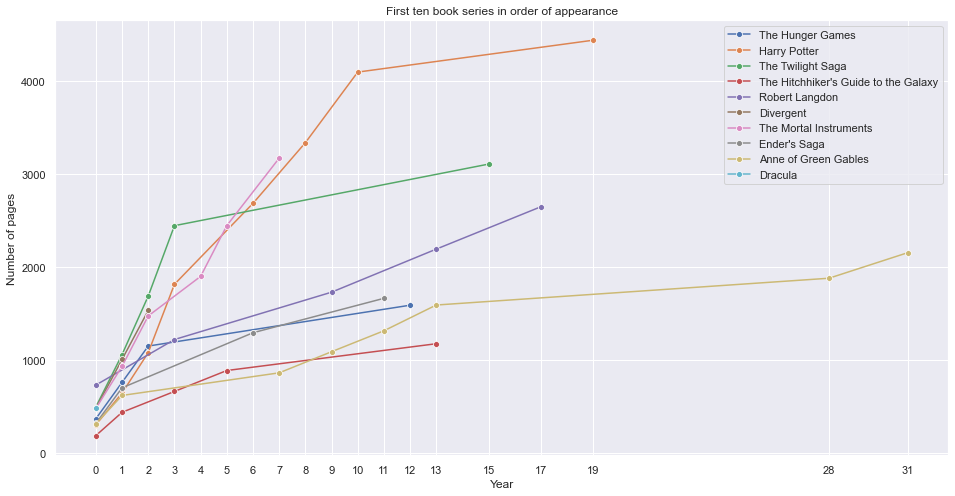

In [9]:
plotting_the_book_series()

## 5. Algorithmic question

### 1. Write a recursive program that, given a string, computes the length of the subsequence of maximum length that is in alphabetical order. Try some examples. Are the examples of short strings correct? Can you find examples that your algorithm does not terminate in reasonable time?

In [48]:
def longest_seq(A, I, m, n): 
    if m == 0 or n == 0: # for terminating the code at the end
        return 0; 
    elif A[m-1] == I[n-1]: # compares the last letters of I and A in every level that function works
        return 1 + longest_seq(A, I, m-1, n-1); 
    else: 
        return max(longest_seq(A, I, m, n-1), longest_seq(A, I, m-1, n)); 

Alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ" # English alphabet in order
Input = input("enter a sequence of alphabets with upper cases: ") # get the input from user

if Input.isupper() and Input.isalpha(): #check if the input is consist of only capital english alphabet or not
    print ("Length of the longest subsequence is: ", longest_seq(Alphabet, Input, len(Alphabet), len(Input)))
else:
    print ('input is not valid')

enter a sequence of alphabets with upper cases: CEGPVQ
Length of the longest subsequence is:  5


### 2. Show that the running time of the algorithm is exponential.

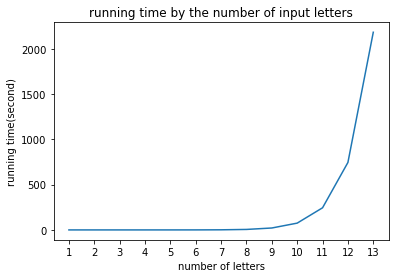

In [39]:
# two empty list to gather the length of each element of the list letters and running time for each element
runtime = []
length = []

# these functions creates a list consist of random letters, starting at one letter and increase the number of letters in each element by one
def randomLetter(v=string.ascii_uppercase):
    return ''.join(random.choice(v))
def listGenerator():
     letter = ""
     for i in range(1,14):
        letter += randomLetter()
        yield letter
letters = list(listGenerator())


for i in range(len(letters)): # iterate through the random list
    Alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    Input = letters[i]
    
    start = time.time() # start the timer
    
    longest_seq(Alphabet, Input, len(Alphabet), len(Input)) # Running the main function
    t = (time.time() - start) # stop the timer and calculate the running time
    l = len(Input)
    runtime.append(t)
    length.append(l)
# draw the plot    
plt.plot(length,runtime)
plt.xticks(np.arange(1, l+1, 1.0))
plt.title('running time by the number of input letters')
plt.xlabel('number of letters')
plt.ylabel('running time(second)')
plt.show();

As we can see on the plot, the running time of the algorithm grows exponentially by increasing the number of letters in the input. That is because the number of steps grows in superpolynomial time, so it must look at every permutation of values. Therefore the running time of the algorithm is exponential.


### 3. Write a program that computes the length of the subsequence of maximum length, using dynamic programming.

We learned how to calculate the longest common subsequence of two strings using dynamic programming. Just by considering alphabets as one of the strings, we can easily calculate the maximum length of characters subsequence for an input string and English alphabets.

In [49]:
def lcs(A , I):
    # get the length of inputs 
    m = len(A)
    n = len(I)
    # dedicate an array to the dynamic programming vector
    L = [[None]*(n+1) for i in range(m+1)] 
    # Loop through the strings to fill the DP vector
    for i in range(m+1): 
        for j in range(n+1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif A[i-1] == I[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j] , L[i][j-1]) 
    # return the length of lcs for A,I  
    return L[m][n]

    
Alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ" # English alphabet in order
Input =  input("enter a sequence of alphabets with upper cases: ") # get the input from user

if Input.isupper() and Input.isalpha(): #check if the input is consist of only capital english alphabets or not
    print ("Length of the longest subsequence is: ", lcs(Alphabet, Input))
else:
    print ('input is not valid')

enter a sequence of alphabets with upper cases: CEGPVQ
Length of the longest subsequence is:  5


### 4. What is its runtime complexity?

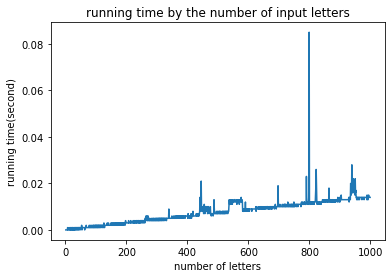

In [37]:
# two empty list to gather the length of each element of the list letters and running time for each element
runtime = []
length = []

# these functions create a list consist of random letters, starting at one letter and increase the number of letters in each element by one
def randomLetter(v=string.ascii_uppercase):
    return ''.join(random.choice(v))
def listGenerator():
     letter = ""
     for i in range(1,1000):
        letter += randomLetter()
        yield letter
letters = list(listGenerator())

for i in range(len(letters)): # iterate through our random list
    Input = letters[i]
    Alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    start = time.time() # start the timer
    
    lcs(Input, Alphabet) # Running the main function
    t = (time.time() - start) # stop the timer and calculate the running time
    l = len(Input)
    runtime.append(t)
    length.append(l)

# draw the plot    
plt.plot(length,runtime)
plt.title('running time by the number of input letters')
plt.xlabel('number of letters')
plt.ylabel('running time(second)')
plt.show();

As we can see on the plot, by increasing the number of letters, no significant difference is visible in runtime(the differences are less than milliseconds). As inferred from the plot, the time complexity is linear. By another logic, it can be argued that because of the presence of two nested for loops with constant running time operations, the runtime complexity is $O(mn)$. This excersice showed that dynamic program is much better than the the recursive program. Since, As the size of the input increases, it becomes almost impossible to use the recursive algorithm.


### Bonus

  We want to prove that this formula is correct for $X[i]$ :

$1$ $X[ i ]$ = the length of the longest sequence of characters in alphabetical order that terminates at the i-th character.

$2$ $X[i] = 1 + max(X[j]; j = 0, ..., i-1 ,$ such that $S[j]<S[i])$

$3$ $X[i] = 1,$ if there does not exist such a j.


* for $i=1:$  $X[1] = 1$  we know that this is correct, since According to the $3$, we can't find such j for it.      
* Now by using inductive logic we assume that  $X[1],...,X[i-1]$  are correct.
* at the index $i$, the subsequence can be  $S[i]$ itself or the subsequence that started before and finish at $i$. Because the order is alphabetical, the second can happen only if  $S[j]<S[i]$ . if the first happen, we need to find maximum lenght by adding 1 to $S[j]$ since we added the letter at position $i$. So $X[i]$ is correct.